# Variance Adaptation, version 16

## Load packages.

In [1]:
require(data.table)
require(deSolve)
require(magrittr)
require(SobolSequence)

require(ggplot2)

Loading required package: data.table
Loading required package: deSolve
Loading required package: magrittr
Loading required package: SobolSequence
Loading required package: ggplot2


## Function to generate simulations.

In [2]:
# Create a multivariate function with specified properties:
#   tmax: maximum time
#   multiplicities: number of correlations each parameter has
#   degrees: polynomial degree of each parameter
#   dimension: the dimension of the output
#   returns a multivariate function of the vector of parameters and time
makeGenerator <- function(multiplicities, degrees, dimension) {

    single <- function(degree) {
      x0 <- runif(1)
      z0 <- runif(1)
      print(x0)
      function(x) {
          if (x < x0)
              0
          else
              z0 * (x - x0)^degree
      }
    }
  
    locations <- lapply(multiplicities, function(m) sample(1:dimension, m))
    functions <- lapply(degrees, single)
    
    start <- runif(dimension, -0.25, 0.75)
    coefs <- matrix(runif(dimension^2, -0.25, 0.75), dimension, dimension)    
    shift <- matrix(runif(dimension^2, -0.25, 0.75), dimension, dimension)
    
    function(x, ts) {
        z <- rep(0, dimension)
        for (i in 1:length(locations))
            for (j in locations[[i]])
                z[j] <- z[j] + functions[[i]](x[i])
        ode(start, ts, function(t, y, params) {list((coefs %*% y) * z * (1 - ((shift %*% y) * z)))})
    }
    
}


## Reproducible random numbers.

In [3]:
RNGkind("Mersenne-Twister", "Inversion", "Rejection")

In [4]:
set.seed(46)

## Create a simulation function.

In [5]:
f <- makeGenerator(c(2, 2, 3), c(0, 1, 2), 3)

[1] 0.5933852
[1] 0.9485472
[1] 0.1029787


## Initial runs.

### Input dimension

In [6]:
k <- 3

### Output dimension.

In [7]:
m <- 3

### Time dimension.

In [8]:
ts <- (0:20) / 2
ts

[1]  0.0  0.5  1.0  1.5  2.0  2.5  3.0  3.5  4.0  4.5  5.0  5.5  6.0  6.5  7.0
[16]  7.5  8.0  8.5  9.0  9.5 10.0

### Batch size for sensitivity experiments.

In [9]:
n <- 100000

### Initial design.

In [10]:
z.design <- sobolSequence.points(2 * k, count = n)
z.design %>% dim

[1] 100000      6

In [11]:
x <- z.design[, 1:(2*k)]
colnames(x) <- c("xa1", "xa2", "xa3", "xb1", "xb2", "xb3")
x <- data.table(j = 1:nrow(x), x)
x %>% head

j,xa1,xa2,xa3,xb1,xb2,xb3
<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,5.421011e-20,5.421011e-20,5.421011e-20,5.421011e-20,5.421011e-20,5.421011e-20
2,5.000000e-01,5.000000e-01,5.000000e-01,5.000000e-01,5.000000e-01,5.000000e-01
3,2.500000e-01,7.500000e-01,7.500000e-01,7.500000e-01,2.500000e-01,2.500000e-01
4,7.500000e-01,2.500000e-01,2.500000e-01,2.500000e-01,7.500000e-01,7.500000e-01
5,6.250000e-01,1.250000e-01,8.750000e-01,6.250000e-01,6.250000e-01,8.750000e-01
6,1.250000e-01,6.250000e-01,3.750000e-01,1.250000e-01,1.250000e-01,3.750000e-01


### Initial results.

In [12]:
y <- NULL
for (row in 1:nrow(x)) {
    ya   <- f(as.numeric(x[row, .(xa1, xa2, xa3)]), ts)[21, 2:4]
    yb   <- f(as.numeric(x[row, .(xb1, xb2, xb3)]), ts)[21, 2:4]
    ya1b <- f(as.numeric(x[row, .(xb1, xa2, xa3)]), ts)[21, 2:4]
    ya2b <- f(as.numeric(x[row, .(xa1, xb2, xa3)]), ts)[21, 2:4]
    ya3b <- f(as.numeric(x[row, .(xa1, xa2, xb3)]), ts)[21, 2:4]
    y <- rbind(
        y,
        data.table(
            j    = row
        ,   i    = rep(1:3, each = 3)
        ,   l    = rep(1:3, times = 3)
        ,   ya   = rep(ya, times = 3)
        ,   yb   = rep(yb, times = 3)
        ,   yaib = c(ya1b, ya2b, ya3b)
        )
    )
 }
y %>% head

j,i,l,ya,yb,yaib
<int>,<int>,<int>,<dbl>,<dbl>,<dbl>
1,1,1,-0.1900320,-0.1900320,-0.1900320
1,1,2,0.5144967,0.5144967,0.5144967
1,1,3,0.4093612,0.4093612,0.4093612
1,2,1,-0.1900320,-0.1900320,-0.1900320
1,2,2,0.5144967,0.5144967,0.5144967
1,2,3,0.4093612,0.4093612,0.4093612


### Partial sensitivities.

In [13]:
st <- merge(
    merge(rbind(
        x[, .(j, i = 1, xa = xa1, xb = xb1)]
    ,   x[, .(j, i = 2, xa = xa2, xb = xb2)]
    ,   x[, .(j, i = 3, xa = xa3, xb = xb3)]
    ), y)
,   y[i == 1, .(scale = sum((ya - yb)^2)), by = .(l)]
,   by = "l"
)[, .(
    j, i, l
,   xa, xb
,   s = (yb - yaib)^2 / scale
,   t = (ya - yaib)^2 / scale
)][order(j, i, l)]
st <- melt(
    melt(
        st[, .(
            Observation = j
        ,   Input       = paste("x", i, sep="_")
        ,   Output      = paste("y", l, sep="_")
        ,   a           = xa
        ,   b           = xb
        ,   First       = s
        ,   Total       = t
        )]
    ,   id.vars = c("Observation", "Input", "Output", "First", "Total")
    ,   variable.name = "Block"
    ,   value.name = "x"
    )
,   id.vars = c("Observation", "Input", "Output", "Block", "x")
,   variable.name = "Sensitivity"
,   value.name = "Index"
)
st %>% head

Observation,Input,Output,Block,x,Sensitivity,Index
<int>,<chr>,<chr>,<fct>,<dbl>,<fct>,<dbl>
1,x_1,y_1,a,5.421011e-20,First,0
1,x_1,y_2,a,5.421011e-20,First,0
1,x_1,y_3,a,5.421011e-20,First,0
1,x_2,y_1,a,5.421011e-20,First,0
1,x_2,y_2,a,5.421011e-20,First,0
1,x_2,y_3,a,5.421011e-20,First,0


### Sensitivity results.

In [14]:
dcast(
    st[Block == "a", .(Index = sum(Index)), by = .(Input, Output, Sensitivity)]
,   Input + Output ~ Sensitivity
,   value.var = "Index"
)[, .(Input, Output, First = 1 - First, Total)]

Input,Output,First,Total
<chr>,<chr>,<dbl>,<dbl>
x_1,y_1,7.589356e-03,1.627807e-02
x_1,y_2,6.247790e-01,9.279178e-01
x_1,y_3,1.471988e-01,4.007174e-01
x_2,y_1,6.577084e-05,9.298862e-05
x_2,y_2,1.188894e-05,4.937494e-05
x_2,y_3,5.645444e-05,1.130454e-04
x_3,y_1,9.836346e-01,9.923513e-01
x_3,y_2,7.237923e-02,3.752851e-01
x_3,y_3,5.993417e-01,8.528978e-01


### Plot partial sensitivities.

#### `xa` and `xb` separately.

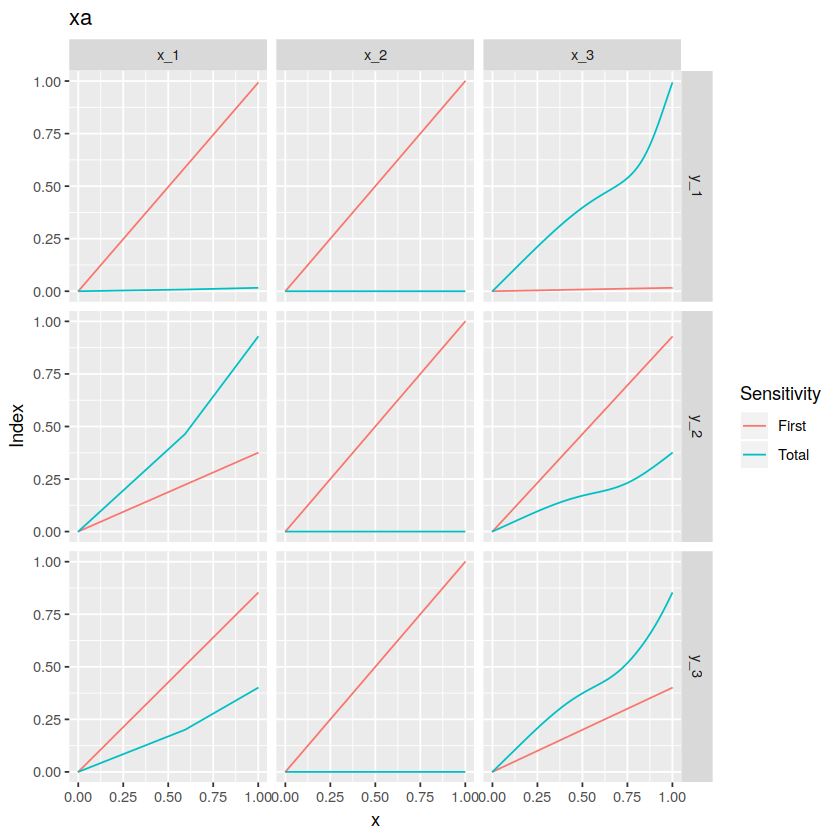

In [15]:
ggplot(
    st[
        Block == "a"
    ][
        order(Input, Output, Sensitivity, x)
    ][, .(
        x
    ,   Index = cumsum(Index)
    ), by = .(Input, Output, Sensitivity)]
,   aes(x = x, y = Index, color = Sensitivity)) +
geom_line() +
facet_grid(Output ~ Input) +
ggtitle("xa")

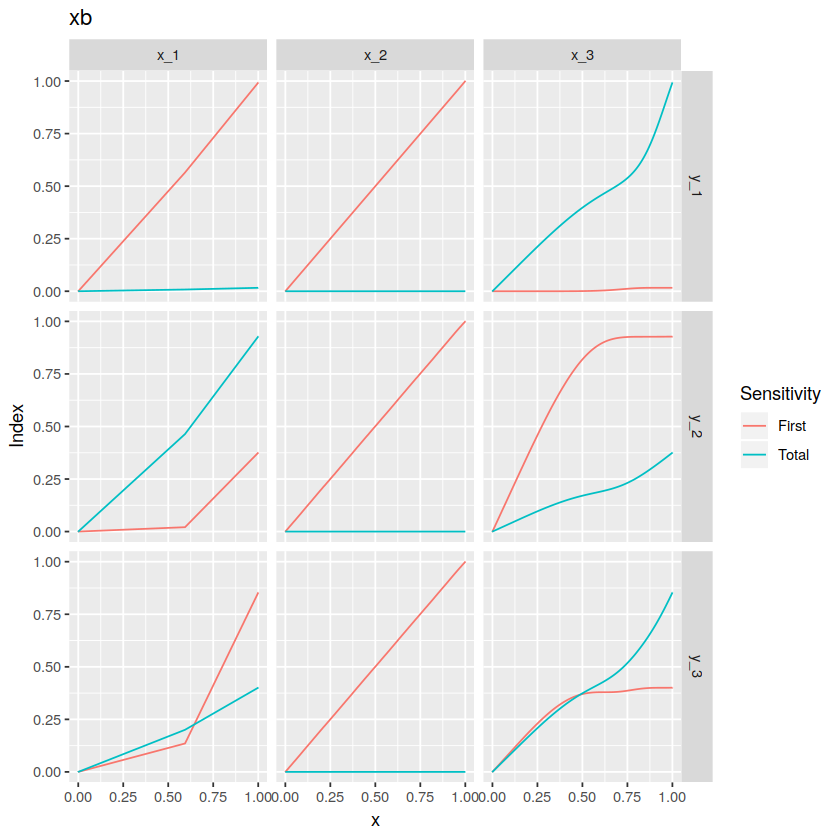

In [16]:
ggplot(
    st[
        Block == "b"
    ][
        order(Input, Output, Sensitivity, x)
    ][, .(
        x
    ,   Index = cumsum(Index)
    ), by = .(Input, Output, Sensitivity)]
,   aes(x = x, y = Index, color = Sensitivity)) +
geom_line() +
facet_grid(Output ~ Input) +
ggtitle("xb")

#### `xa` and `xb` interleaved.

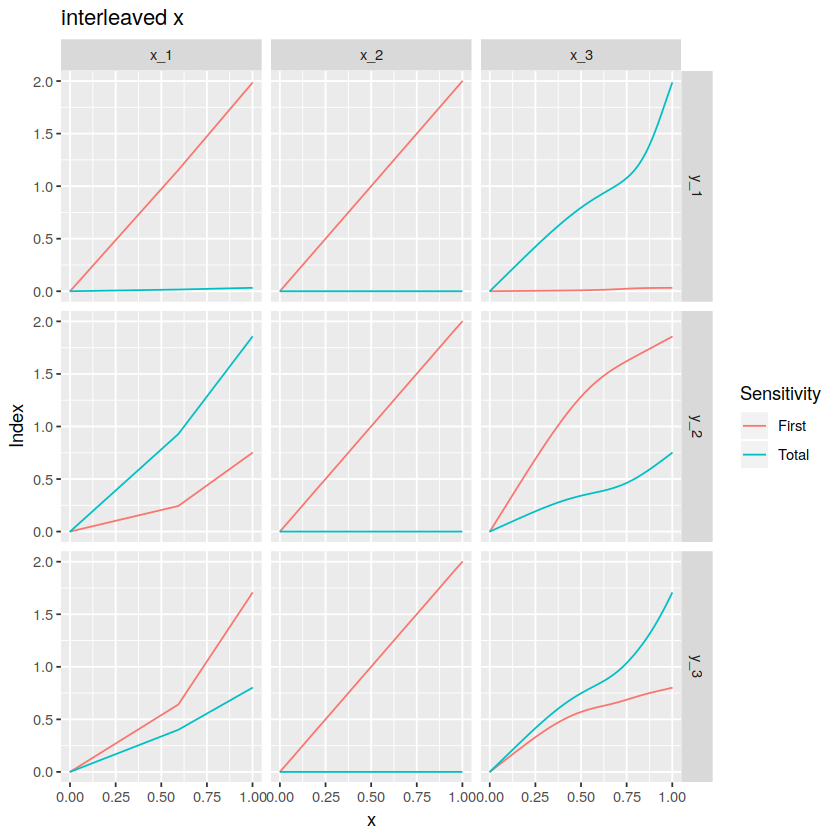

In [17]:
ggplot(
    st[
        order(Input, Output, Sensitivity, x)
    ][, .(
        x
    ,   Index = cumsum(Index)
    ), by = .(Input, Output, Sensitivity)]
,   aes(x = x, y = Index, color = Sensitivity)) +
geom_line() +
facet_grid(Output ~ Input) +
ggtitle("interleaved x")

#### Minimum and maximum of `xa` and `xb`.

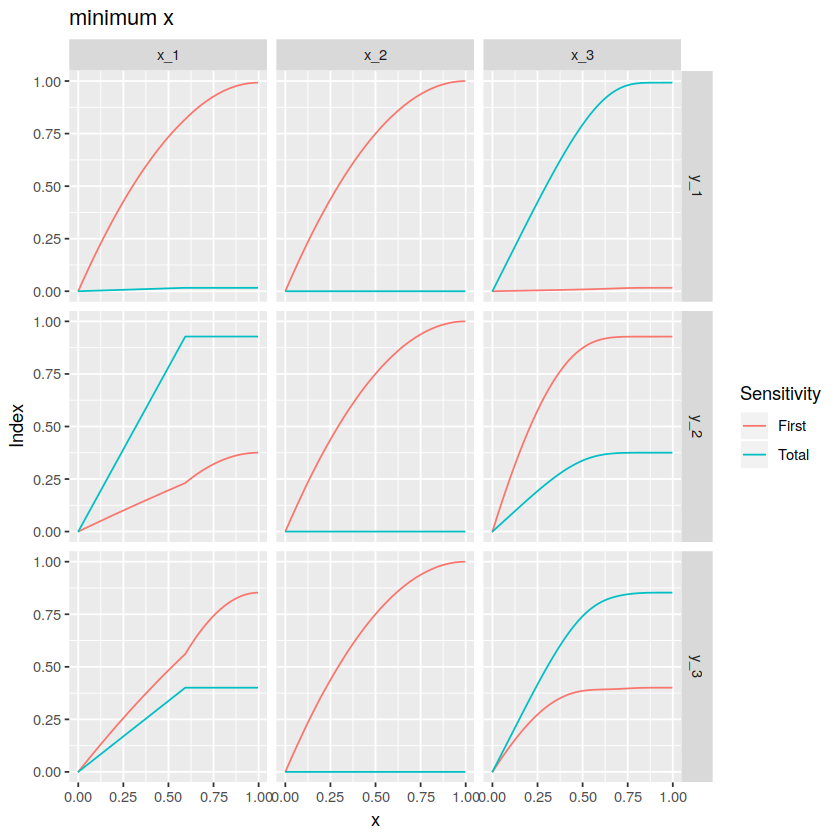

In [18]:
ggplot(
    st[, .(
        x = min(x)
    ), by = .(
        Observation
    ,   Input
    ,   Output
    ,   Sensitivity
    ,   Index
    )][
        order(Input, Output, Sensitivity, x)
    ][, .(
        x
    ,   Index = cumsum(Index)
    ), by = .(Input, Output, Sensitivity)]
,   aes(x = x, y = Index, color = Sensitivity)) +
geom_line() +
facet_grid(Output ~ Input) +
ggtitle("minimum x")

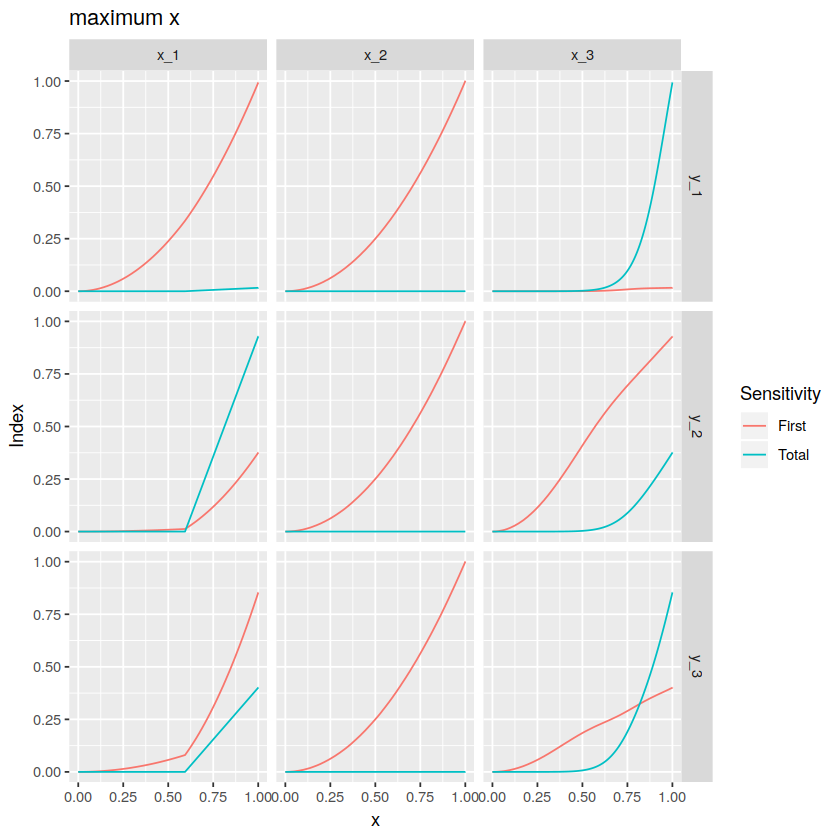

In [19]:
ggplot(
    st[, .(
        x = max(x)
    ), by = .(
        Observation
    ,   Input
    ,   Output
    ,   Sensitivity
    ,   Index
    )][
        order(Input, Output, Sensitivity, x)
    ][, .(
        x
    ,   Index = cumsum(Index)
    ), by = .(Input, Output, Sensitivity)]
,   aes(x = x, y = Index, color = Sensitivity)) +
geom_line() +
facet_grid(Output ~ Input) +
ggtitle("maximum x")

#### Mean of `xa` and `xb`.

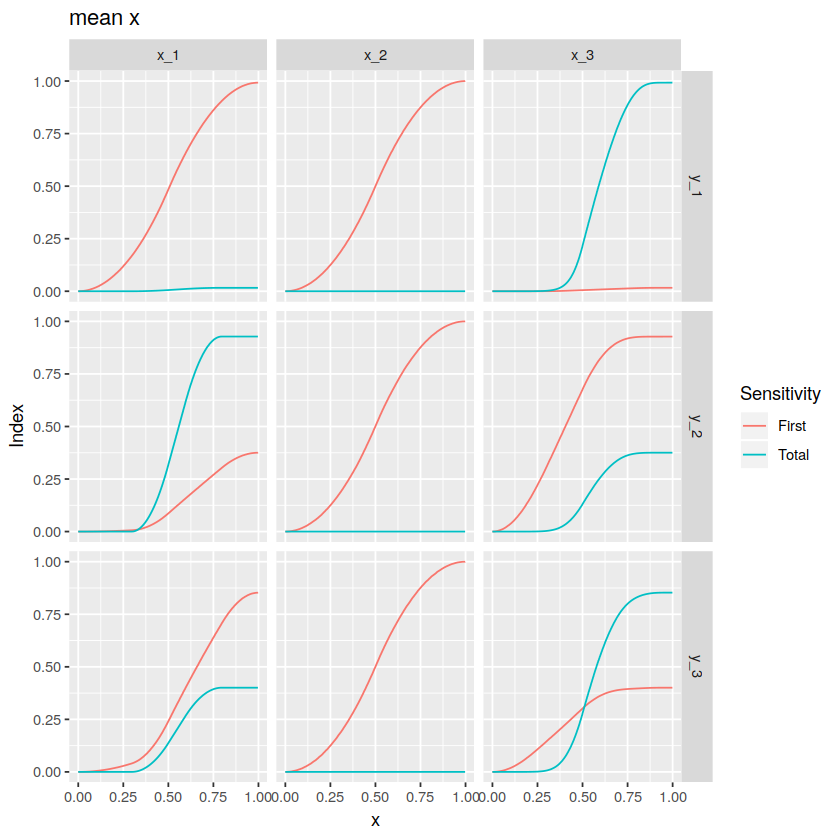

In [20]:
ggplot(
    st[, .(
        x = mean(x)
    ), by = .(
        Observation
    ,   Input
    ,   Output
    ,   Sensitivity
    ,   Index
    )][
        order(Input, Output, Sensitivity, x)
    ][, .(
        x
    ,   Index = cumsum(Index)
    ), by = .(Input, Output, Sensitivity)]
,   aes(x = x, y = Index, color = Sensitivity)) +
geom_line() +
facet_grid(Output ~ Input) +
ggtitle("mean x")

### Sampling density.

In [21]:
st %>% head

Observation,Input,Output,Block,x,Sensitivity,Index
<int>,<chr>,<chr>,<fct>,<dbl>,<fct>,<dbl>
1,x_1,y_1,a,5.421011e-20,First,0
1,x_1,y_2,a,5.421011e-20,First,0
1,x_1,y_3,a,5.421011e-20,First,0
1,x_2,y_1,a,5.421011e-20,First,0
1,x_2,y_2,a,5.421011e-20,First,0
1,x_2,y_3,a,5.421011e-20,First,0


#### Check that the Sobol' sequence filled space uniformly.

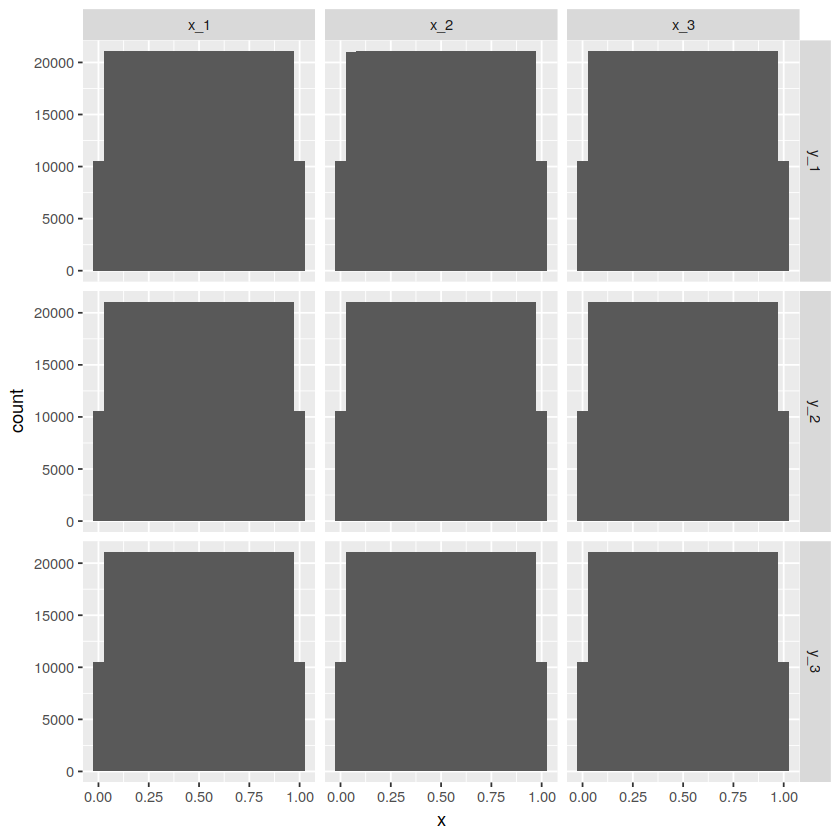

In [22]:
ggplot(st, aes(x = x)) + geom_histogram(bins = 20) + facet_grid(Output ~ Input)

#### Compute the sampling density.

In [23]:
epsilon <- 1e-4
z <- st[
    Sensitivity == "Total" # & Index > 0
,   .(
        xmin   = min(x) - epsilon / 2
    ,   xmax   = max(x) + epsilon / 2
    ,   Index  = mean(Index)
    ,   Weight = 1
    )
,   by = .(Input, Output, Observation)
]
z <- z[, .(
    Input
,   Output
,   xmin
,   xmax
,   Index  = Index  / (xmax - xmin + epsilon)
,   Weight = Weight / (xmax - xmin + epsilon)
)]
z %>% head

Input,Output,xmin,xmax,Index,Weight
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
x_1,y_1,-5e-05,5e-05,0,5000
x_1,y_2,-5e-05,5e-05,0,5000
x_1,y_3,-5e-05,5e-05,0,5000
x_2,y_1,-5e-05,5e-05,0,5000
x_2,y_2,-5e-05,5e-05,0,5000
x_2,y_3,-5e-05,5e-05,0,5000


In [24]:
z <- rbind(
    z[, .(x = xmin, Index          , Weight           ), by = .(Input, Output)]
,   z[, .(x = xmax, Index = - Index, Weight = - Weight), by = .(Input, Output)]
)[order(x)][, .(x, Index = cumsum(Index), Weight = cumsum(Weight)), by = .(Input, Output)]
z %>% head

Input,Output,x,Index,Weight
<chr>,<chr>,<dbl>,<dbl>,<dbl>
x_1,y_1,-5.000000e-05,0.000000e+00,5000.000
x_1,y_1,-4.237061e-05,0.000000e+00,5007.850
x_1,y_1,-3.474121e-05,1.182295e-07,5009.008
x_1,y_1,-3.474121e-05,9.340113e-07,5010.321
x_1,y_1,-2.711182e-05,9.340113e-07,5012.636
x_1,y_1,-1.948242e-05,9.340113e-07,5020.154


#### Plot the sampling density.

Warning message:
“Removed 2 rows containing non-finite values (stat_smooth).”

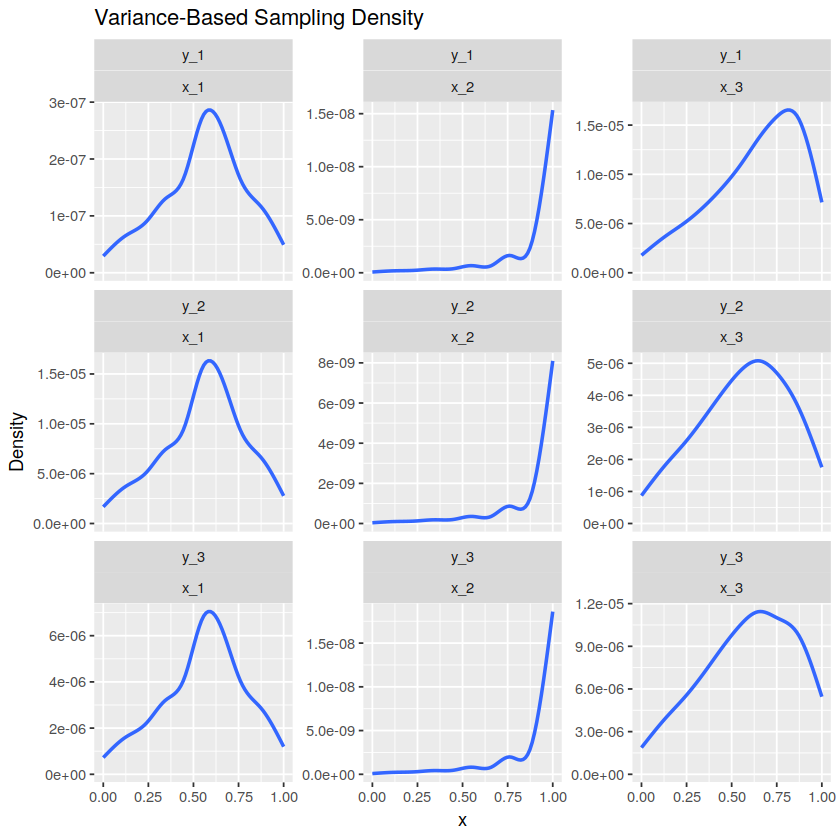

In [25]:
ggplot(
    z[
        , .(Density = sum(Index) / (sum(Weight) + 1e-10)), by = .(Input, Output, x)
    ][
        order(Input, Output, x)
    ]
,   aes(x = x, y = Density)
) +
geom_smooth(method = "gam", formula = y ~ s(x, bs = "cs")) +
scale_y_continuous(limits = c(0, NA)) +
facet_wrap(Output ~ Input, scales = "free_y") +
ggtitle("Variance-Based Sampling Density")

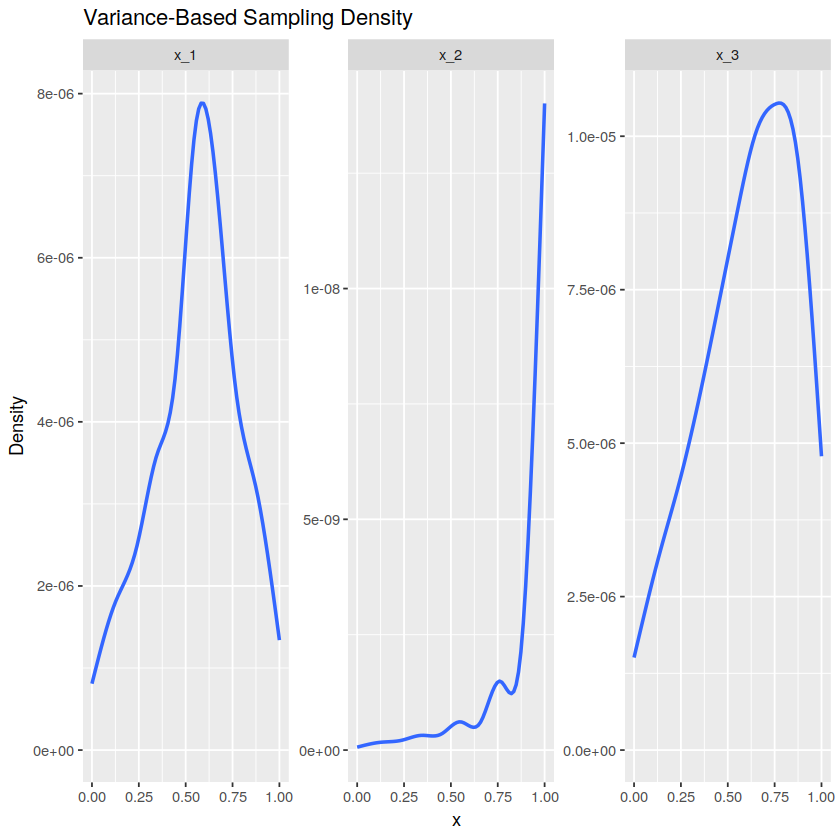

In [26]:
ggplot(
    z[
        , .(Density = sum(Index) / (sum(Weight) + 1e-10)), by = .(Input, x)
    ][
        order(Input, x)
    ]
,   aes(x = x, y = Density)
) +
geom_smooth(method = "gam", formula = y ~ s(x, bs = "cs")) +
scale_y_continuous(limits = c(0, NA)) +
facet_wrap(. ~ Input, scales = "free_y") +
ggtitle("Variance-Based Sampling Density")

Warning message:
“Removed 3 rows containing missing values (geom_smooth).”

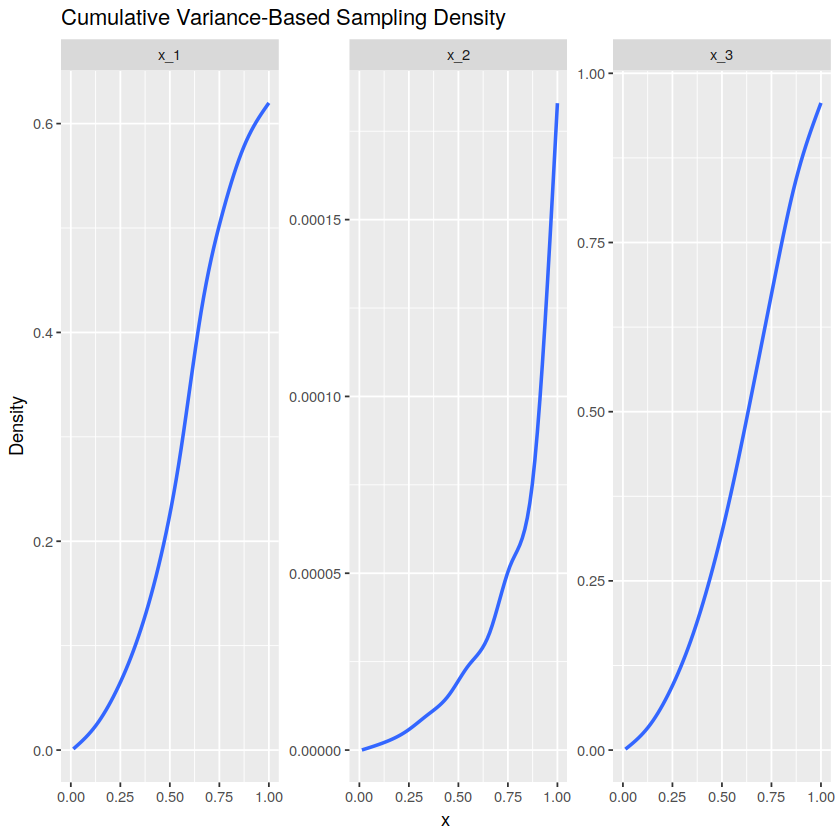

In [27]:
ggplot(
    z[
        , .(Density = sum(Index) / (sum(Weight) + 1e-10)), by = .(Input, x)
    ][
        order(Input, x)
    ][
        , .(x, Density = cumsum(Density)), by = .(Input)
    ]
,   aes(x = x, y = Density)
) +
geom_smooth(method = "gam", formula = y ~ s(x, bs = "cs")) +
scale_y_continuous(limits = c(0, NA)) +
facet_wrap(. ~ Input, scales = "free_y") +
ggtitle("Cumulative Variance-Based Sampling Density")